In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.preprocessing     # For StandardScaler
import sklearn.linear_model      # For LogisticRegression
import sklearn.neural_network    # For MLPClassifier
import torch
import warnings
import os
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)  # Annoying
np.set_printoptions(precision=3, suppress=True)  # Print as 0.001 instead of 9.876e-4

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
%cd ..

%cd /content/drive/MyDrive/Dataset 1/Colorectal Cancer
import shutil

# Set the source folder and destination folder paths
source_folder = '/content/drive/MyDrive/Dataset 1/Colorectal Cancer '
# path to your dataset
destination_folder = '/content/Dataset1'

import shutil

# Remove the existing folder if it exists
if os.path.exists(destination_folder):
    shutil.rmtree(destination_folder)

# Copy the dataset to the destination folder
shutil.copytree(source_folder, destination_folder)





/
[Errno 2] No such file or directory: '/content/drive/MyDrive/Dataset 1/Colorectal Cancer'
/


'/content/Dataset1'

# Nouvelle section

In [7]:

%cd /content/Dataset1


# List files in the destination folder
os.listdir(destination_folder)





/content/Dataset1


['MUS', 'NORM', 'STR']

In [8]:
# Check the number of .tif files and missing data
expected_count = 6000  # Replace with the expected count

# List all .tif files in the dataset directory
all_tif_files = []
for root, dirs, files in os.walk(destination_folder):
    tif_files = [file for file in files if file.endswith('.tif')]
    all_tif_files.extend(tif_files)

unique_tif_files = list(set(all_tif_files))
print(f"Total .tif images found: {len(unique_tif_files)}")

# Remove Tiff duplicates in Dataset 1
filtered_tif_files = [file for file in unique_tif_files if "(1)" not in file and "(2)" not in file]


# Calculate the total count of .tif files after removing duplicates
total_count = len(filtered_tif_files)


# Print the results
print(f"Total unique .tif images found: {total_count}")
print(f"Expected count: {expected_count}")
print(f"Missing data: {expected_count - total_count} files are missing.")


Total .tif images found: 6010
Total unique .tif images found: 6000
Expected count: 6000
Missing data: 0 files are missing.


In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms

# List all image files in the dataset directory
image_paths = []
for root, dirs, files in os.walk(destination_folder):
    for file in files:
        image_paths.append(os.path.join(root, file))

# Define mean and std values for image normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


In [10]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot
from matplotlib import image
import time

In [11]:
def load_data(path, test_split,batch_size,input_size):
   transform_dict = {
      'scr': transforms.Compose(
      [ transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
      ])}
   data = datasets.ImageFolder(root=path, transform=transform_dict['scr'])

   dataset_size = len(data)
   test_size = int(dataset_size * test_split)
   train_size = dataset_size - test_size

   train_dataset, test_dataset = td.random_split(data, [train_size, test_size])
   train_loader = td.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=0)
   test_loader = td.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0)
   return train_loader, test_loader

In [12]:
path = destination_folder
test_split = 0.3
batch_size = 100
input_size = (224, 224)


train_loader, test_loader = load_data(path, test_split, batch_size, input_size)
print(len(train_loader))
print(len(test_loader))


43
19


Batch Shape: torch.Size([100, 3, 224, 224])


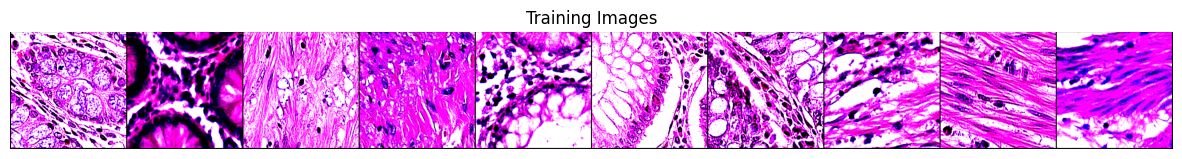

Batch Shape: torch.Size([100, 3, 224, 224])


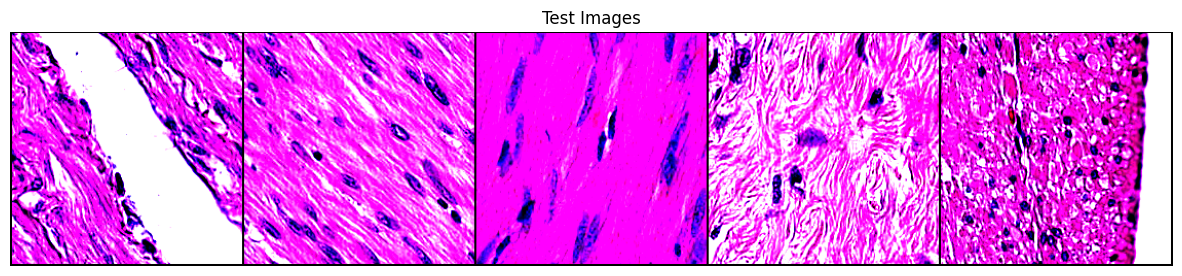

In [13]:
import matplotlib.pyplot as plt
import torchvision

# Assuming train_loader is already defined

# Function to display a subset of images in a grid
def show_images(images, title, num_images=10):

    grid = torchvision.utils.make_grid(images[:num_images], nrow=num_images)

    grid = grid.permute(1, 2, 0)
    grid = grid.numpy()
    plt.figure(figsize=(15, 15))
    plt.imshow(grid)
    plt.title(title)
    plt.axis('off')
    plt.show()


# Iterate through one batch from the train_loader
for inputs, labels in train_loader:
    print(f"Batch Shape: {inputs.shape}")
    show_images(inputs, 'Training Images', num_images=10)
    break

# Iterate through one batch from the test_loader
for inputs, labels in test_loader:
    print(f"Batch Shape: {inputs.shape}")
    show_images(inputs, 'Test Images', num_images=5)
    break





In [14]:

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models  # Add this import statement
from sklearn.manifold import TSNE
import torch.nn as nn
import torch.optim as optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 3
print(device)


# Print the number of samples in training and testing sets

num_batches = len(train_loader)
print(f"Number of batches in train_loader: {num_batches}")

total_train_samples = num_batches * batch_size
print(f"Total number of samples in the training set: {total_train_samples}")

num_test_batches = len(test_loader)
print(f"Number of batches in train_loader: {num_test_batches}")

total_test_samples = num_test_batches * batch_size
print(f"Total number of samples in the training set: {total_test_samples}")





cuda
Number of batches in train_loader: 43
Total number of samples in the training set: 4300
Number of batches in train_loader: 19
Total number of samples in the training set: 1900


In [15]:

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models  # Add this import statement
from sklearn.manifold import TSNE
import torch.nn as nn
import torch.optim as optim




# # Define ResNet-18 architecture
# class CustomResNet18(nn.Module):
#     def __init__(self):
#         super(CustomResNet18, self).__init__()
#         self.resnet18 = resnet18(pretrained=False) #not pretrained from scratch
#         self.resnet18.fc = nn.Linear(512, num_classes)  # Change the output layer to match the number of classes

#     def forward(self, x):
#         return self.resnet18(x)

# Define ResNet-18 architecture
class CustomResNet18(nn.Module):
    def __init__(self):
        super(CustomResNet18, self).__init__()
        self.resnet18 = resnet18(weights=None)  # Use weights=None instead of pretrained=False
        self.resnet18.fc = nn.Linear(512, num_classes)  # Change the output layer to match the number of classes

    def forward(self, x):
        return self.resnet18(x)


# Instantiate the model, loss function, and optimizer
#num_classes = len(image_paths)  # Assuming each image represents a different class
# model = CustomResNet18().to(device)
# #model = model.t

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

model = models.resnet18(pretrained=True)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

class_to_index = {"MUS": 0, "NORM": 1, "STR": 2}


# Training the model
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Learning rate adjustment at the end of each epoch
    scheduler.step()

    # Validation set evaluation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for val_data in test_loader:
            val_inputs, val_labels = val_data[0].to(device), val_data[1].to(device)

            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()

            _, predicted = val_outputs.max(1)
            total += val_labels.size(0)
            correct += predicted.eq(val_labels).sum().item()

    average_val_loss = val_loss / len(test_loader)
    val_accuracy = correct / total

    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%')





/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 138MB/s]


Epoch [1/10], Training Loss: 1.0418, Validation Loss: 0.4611, Validation Accuracy: 85.75%
Epoch [2/10], Training Loss: 0.0099, Validation Loss: 0.0675, Validation Accuracy: 97.56%
Epoch [3/10], Training Loss: 0.0120, Validation Loss: 0.0471, Validation Accuracy: 98.67%
Epoch [4/10], Training Loss: 0.3340, Validation Loss: 0.0311, Validation Accuracy: 98.89%
Epoch [5/10], Training Loss: 0.6215, Validation Loss: 0.0313, Validation Accuracy: 99.06%
Epoch [6/10], Training Loss: 0.0036, Validation Loss: 0.0275, Validation Accuracy: 98.95%
Epoch [7/10], Training Loss: 0.0724, Validation Loss: 0.0241, Validation Accuracy: 99.28%
Epoch [8/10], Training Loss: 0.0129, Validation Loss: 0.0261, Validation Accuracy: 99.28%
Epoch [9/10], Training Loss: 0.7753, Validation Loss: 0.0228, Validation Accuracy: 99.22%
Epoch [10/10], Training Loss: 3.0402, Validation Loss: 0.0267, Validation Accuracy: 99.17%


In [16]:
# # Lists to store true labels and predicted labels
# true_labels = []
# predicted_labels = []

# # Iterate through the test set
# # with torch.no_grad():
#     for inputs, labels in train_loader:
#         inputs = inputs.to(device)
#         labels = labels.to(device)
#         # outputs = model(inputs)

#         # Get predicted labels
#         _, predictions = torch.max(outputs, 1)

#         true_labels.extend(labels.cpu().numpy())
#         predicted_labels.extend(predictions.cpu().numpy())

# # Generate confusion matrix
# conf_matrix = confusion_matrix(true_labels, predicted_labels)

# # Print confusion matrix
# print("Confusion Matrix:")
# print(conf_matrix)

# # Generate classification report (includes precision, recall, F1-score)
# class_report = classification_report(true_labels, predicted_labels)

# # Print classification report
# print("Classification Report:")
# print(class_report)


In [17]:
# Test set evaluation
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for test_data in test_loader:
        test_inputs, test_labels = test_data[0].to(device), test_data[1].to(device)

        test_outputs = model(test_inputs)
        test_loss += criterion(test_outputs, test_labels).item()

        _, predicted_test = test_outputs.max(1)
        total_test += test_labels.size(0)
        correct_test += predicted_test.eq(test_labels).sum().item()

average_test_loss = test_loss / len(test_loader)
test_accuracy = correct_test / total_test

print(f'Test Loss: {average_test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')


# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/resnet18.pt')


Test Loss: 0.0267, Test Accuracy: 99.17%


In [18]:
!cp /content/resnet18.pt /content/gdrive/My\ Drive/


cp: cannot stat '/content/resnet18.pt': No such file or directory


In [19]:
from sklearn.metrics import confusion_matrix, classification_report

# Set the model to evaluation mode
model.eval()

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the test set
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)

        # Get predicted labels
        _, predictions = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report (includes precision, recall, F1-score)
class_report = classification_report(true_labels, predicted_labels)

# Print classification report
print("Classification Report:")
print(class_report)


Confusion Matrix:
[[597   0   4]
 [  0 624   0]
 [  6   5 567]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       601
           1       0.99      1.00      1.00       624
           2       0.99      0.98      0.99       578

    accuracy                           0.99      1803
   macro avg       0.99      0.99      0.99      1803
weighted avg       0.99      0.99      0.99      1803



Extracted Features Shape: (1803, 2)


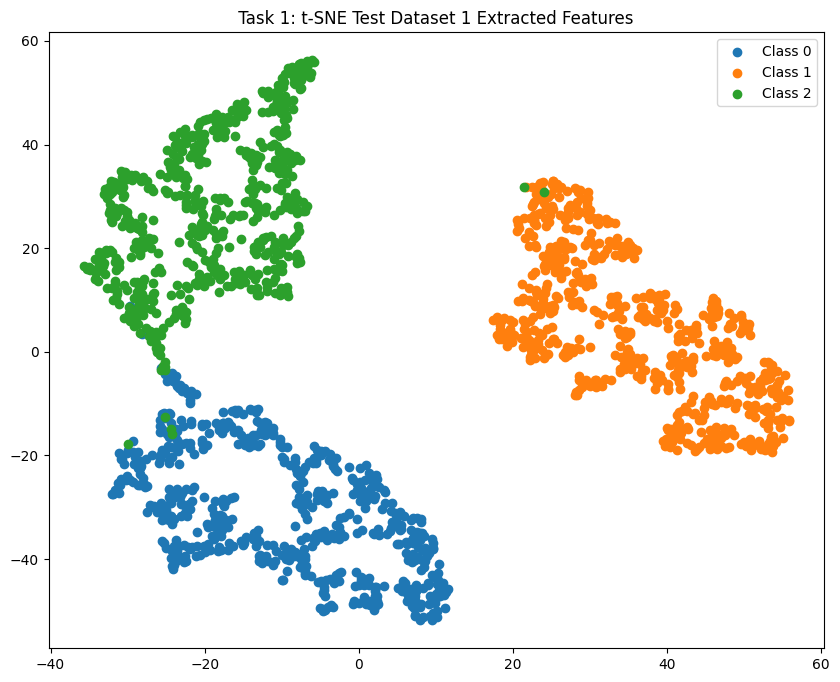

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models  #
from sklearn.manifold import TSNE
import torch.nn as nn
import torch.optim as optim

# Evaluate using t-SNE
model.eval()
class_labels = {0: 'MUS', 1: 'NORM', 2: 'STR'}

num_classes = len(class_labels)

# Extract feature vectors for t-SNE
feature_vectors = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        feature_vectors.append(outputs.cpu().numpy())
        true_labels.append(labels.cpu().numpy())


# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
extracted_features = tsne.fit_transform(np.vstack(feature_vectors))

print("Extracted Features Shape:", extracted_features.shape)


flat_true_labels = np.concatenate(true_labels)


# Check for any NaN or infinite values in the extracted features
if np.isnan(extracted_features).any() or np.isinf(extracted_features).any():
    print("NaN or infinite values found in extracted features.")

# Plot the t-SNE embeddings
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    indices = flat_true_labels == i
    plt.scatter(extracted_features[indices, 0], extracted_features[indices, 1], label=f'Class {i}')

plt.title(' Task 1: t-SNE Test Dataset 1 Extracted Features ')
plt.legend()
plt.show()




Extracted Features Shape: (4207, 2)


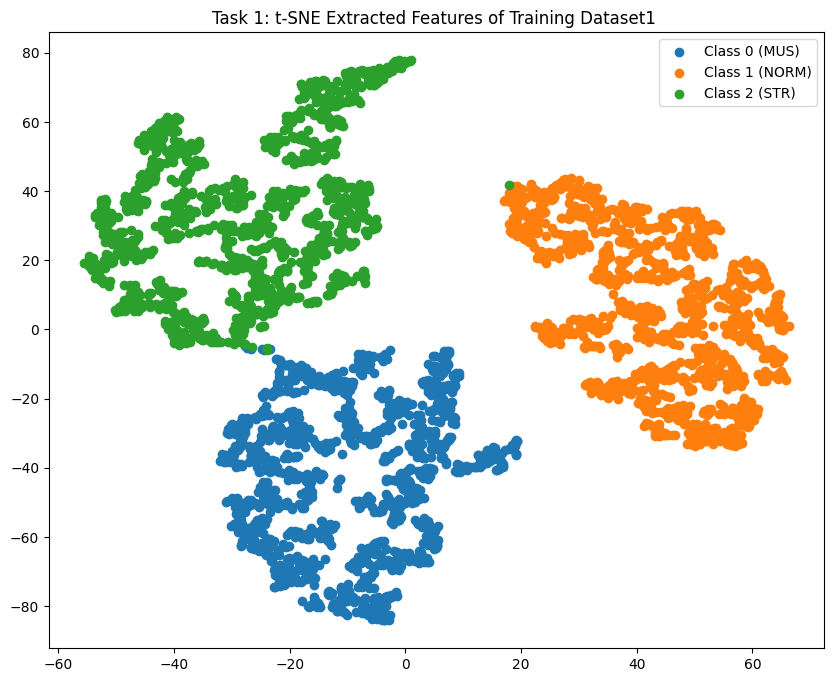

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from sklearn.manifold import TSNE
import torch.nn as nn
import torch.optim as optim
# Evaluate using t-SNE


model.eval()
class_labels = {0: 'MUS', 1: 'NORM', 2: 'STR'}

num_classes = len(class_labels)

# Extract feature vectors for t-SNE
feature_vectors = []
true_labels = []

with torch.no_grad():
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        feature_vectors.append(outputs.cpu().numpy())
        true_labels.append(labels.cpu().numpy())


# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
extracted_features = tsne.fit_transform(np.vstack(feature_vectors))

print("Extracted Features Shape:", embedded_features.shape)


flat_true_labels = np.concatenate(true_labels)


# Check for any NaN or infinite values in the embedded features
if np.isnan(extracted_features).any() or np.isinf(extracted_features).any():
    print("NaN or infinite values found in embedded features.")

# Plot the t-SNE embeddings
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    indices = flat_true_labels == i
    plt.scatter(extracted_features[indices, 0], extracted_features[indices, 1], label=f'Class {i} ({class_labels[i]})')


plt.title('Task 1: t-SNE Extracted Features of Training Dataset1 ')
plt.legend()
plt.show()


#gpu setting colab